In [73]:
import pandas as pd
import numpy as np

In [2]:
full_channel_df = pd.read_json('../luna_crash_dataset/luna/LUNA_FullChannel_GDAX_20220511_17hr.json', lines=True)

In [3]:
ticker_df = pd.read_json('../luna_crash_dataset/luna/LUNA_Ticker_GDAX_20220511_17hr.json', lines=True)

In [4]:
full_channel_df.columns

Index(['order_id', 'order_type', 'size', 'price', 'client_oid', 'type', 'side',
       'product_id', 'time', 'sequence', 'remaining_size', 'trade_id',
       'maker_order_id', 'taker_order_id', 'reason', 'funds', 'old_size',
       'new_size'],
      dtype='object')

In [5]:
full_channel_df.time = pd.to_datetime(full_channel_df.time)
full_channel_df['timestamp'] = full_channel_df['time'].astype('int64')

ticker_df.time = pd.to_datetime(ticker_df.time)
ticker_df['timestamp'] = ticker_df['time'].astype('int64')

In [6]:
full_channel_df = full_channel_df.sort_values(by='timestamp')
ticker_df = ticker_df.sort_values(by='timestamp')

In [7]:
full_channel_df.time.describe()

count                                 768272
mean     2022-05-11 16:26:23.892738816+00:00
min         2022-05-11 15:59:00.796073+00:00
25%      2022-05-11 16:10:33.844806656+00:00
50%      2022-05-11 16:24:30.681201920+00:00
75%      2022-05-11 16:41:44.489450752+00:00
max         2022-05-11 16:59:52.935290+00:00
Name: time, dtype: object

In [8]:
full_channel_df.count()

order_id          729838
order_type        251156
size              288158
price             763552
client_oid        251156
type              768272
side              768272
product_id        768272
time              768272
sequence          768272
remaining_size    477233
trade_id           38434
maker_order_id     38434
taker_order_id     38434
reason            250056
funds               1870
old_size              17
new_size              17
timestamp         768272
dtype: int64

In [9]:
full_channel_df.head()

,order_id,order_type,size,price,client_oid,type,side,product_id,time,sequence,remaining_size,trade_id,maker_order_id,taker_order_id,reason,funds,old_size,new_size,timestamp
0,04074a2a-ff4d-40f8-a921-d88ece5d1562,limit,281.146,2.06,0278c289-d977-44e0-9b3a-ff4e82b8dda5,received,buy,WLUNA-USD,2022-05-11 15:59:00.796073+00:00,1292598749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1652284740796073000
1,04074a2a-ff4d-40f8-a921-d88ece5d1562,NaN,NaN,2.06,NaN,open,buy,WLUNA-USD,2022-05-11 15:59:00.796073+00:00,1292598750,281.146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1652284740796073000
5,NaN,NaN,14.000,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598754,NaN,7884081.0,811f8a8f-53dc-4b0b-b106-9f6cba1eef4b,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,NaN,NaN,1652284740813739000
6,811f8a8f-53dc-4b0b-b106-9f6cba1eef4b,NaN,NaN,2.33,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598755,0.000,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284740813739000
3,NaN,NaN,374.806,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598752,NaN,7884080.0,474813db-2329-4aba-a07b-b1adea78da8f,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,NaN,NaN,1652284740813739000


In [10]:
full_channel_df.timestamp.head()

0    1652284740796073000
1    1652284740796073000
5    1652284740813739000
6    1652284740813739000
3    1652284740813739000
Name: timestamp, dtype: int64

In [11]:
ticker_df.columns

Index(['type', 'sequence', 'product_id', 'price', 'open_24h', 'volume_24h',
       'low_24h', 'high_24h', 'volume_30d', 'best_bid', 'best_ask', 'side',
       'time', 'trade_id', 'last_size', 'timestamp'],
      dtype='object')

In [12]:
ticker_df.head()

,type,sequence,product_id,price,open_24h,volume_24h,low_24h,high_24h,volume_30d,best_bid,best_ask,side,time,trade_id,last_size,timestamp
0,ticker,1292614427,WLUNA-USD,2.42,31.4,3.773185e+07,0.95,32.7,5.215304e+07,2.42,2.44,sell,2022-05-11 15:59:59.959016+00:00,7884870,11.525,1652284799959016000
1,ticker,1292614429,WLUNA-USD,2.42,31.4,3.773188e+07,0.95,32.7,5.215306e+07,2.42,2.44,sell,2022-05-11 15:59:59.959016+00:00,7884871,28.646,1652284799959016000
3,ticker,1292614433,WLUNA-USD,2.42,31.4,3.773217e+07,0.95,32.7,5.215335e+07,2.42,2.44,sell,2022-05-11 15:59:59.959016+00:00,7884873,274.088,1652284799959016000
2,ticker,1292614431,WLUNA-USD,2.42,31.4,3.773190e+07,0.95,32.7,5.215308e+07,2.42,2.44,sell,2022-05-11 15:59:59.959016+00:00,7884872,14.000,1652284799959016000
4,ticker,1292614468,WLUNA-USD,2.44,31.4,3.773217e+07,0.95,32.7,5.215335e+07,2.42,2.44,buy,2022-05-11 16:00:00.215969+00:00,7884874,1.100,1652284800215969000


In [13]:
price_df = ticker_df[['timestamp', 'price', 'best_bid', 'best_ask', 'time']].copy()
price_df['mid_price'] = (price_df['best_bid'] + price_df['best_ask']) / 2

In [52]:
orders_df = pd.merge(
    price_df.drop(columns=['time', 'price']),
    full_channel_df,
    on='timestamp',
    how='inner'
)

In [55]:
orders_df.columns

Index(['timestamp', 'best_bid', 'best_ask', 'mid_price', 'order_id',
       'order_type', 'size', 'price', 'client_oid', 'type', 'side',
       'product_id', 'time', 'sequence', 'remaining_size', 'trade_id',
       'maker_order_id', 'taker_order_id', 'reason', 'funds', 'old_size',
       'new_size'],
      dtype='object')

In [56]:
orders_df = orders_df[['timestamp', 'price', 'best_bid', 'best_ask', 'mid_price', 'side', 'order_type', 'reason', 'size', 'time']]

## Velocities

### Limit buy
![alt text](limit_buy.png "limit buy")

### Limit sell
![alt text](limit_sell.png "limit sell")

### Limit buy cancel
![alt text](limit_buy_cancel.png "limit buy cancel")

### Limit sell cancel
![alt text](limit_sell_cancel.png "limit sell cancel")


In [75]:
def calculate_buy_velocity(price: float, alpha: float, delta_t_ns: int, bid: float):
    return (price - (bid - alpha)) / delta_t_ns


def calculate_sell_velocity(price: float, alpha: float, delta_t_ns: int, ask: float):
    return (price - (ask + alpha)) / delta_t_ns


def calculate_buy_cancel_velocity(price: float, alpha: float, delta_t_ns: int, bid: float):
    return ((bid - alpha) - price) / delta_t_ns


def calculate_sell_cancel_velocity(price: float, alpha: float, delta_t_ns: int, ask: float):
    return ((ask + alpha) - price) / delta_t_ns


In [197]:
from matplotlib import pyplot as plt


def plot_mid_price(price_df, limit=100):
    price_df = price_df.head(limit)
    plt.figure(figsize=(10, 5))
    plt.plot(price_df.time, price_df.mid_price, label='Mid Price')
    plt.xlabel('Timestamp')
    plt.ylabel('Mid Price')
    plt.title('Mid Price over Time')
    plt.legend()
    plt.show()


def plot_cumulative_momentum(cumulative_momentum):
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_momentum)
    plt.xlabel('Timestamp')
    plt.ylabel('Cumulative Momentum')
    plt.title('Cumulative Momentum over Time')
    plt.show()


In [221]:
delta_t_ns = 100_000_000
delta_t_sec = delta_t_ns / 1_000_000_000
start_t_ns = full_channel_df.timestamp.min()
end_t_ns = full_channel_df.timestamp.max()

# alpha = (ticker_df.price.max() - ticker_df.price.min()) / 4
alpha = 0.5

In [276]:

import tqdm


def calculate_momentum(orders_df, alpha, delta_t_ns, start_t_ns, end_t_ns):
    accum_df = None

    counter = 0

    cumulative_momentum = []

    for t in tqdm.tqdm(range(start_t_ns, end_t_ns, delta_t_ns)):
        time_mask = orders_df.timestamp.between(t, t + delta_t_ns, inclusive='left')
        active_area_mask = orders_df.price.between(orders_df.best_bid - alpha, orders_df.best_ask + alpha)
        tmp_df = orders_df[time_mask & active_area_mask].copy()
        tmp_df['velocity'] = np.nan
        tmp_df['momentum'] = np.nan

        buy_mask = (tmp_df.order_type == 'limit') & (tmp_df.side == 'buy')
        sell_mask = (tmp_df.order_type == 'limit') & (tmp_df.side == 'sell')
        buy_cancel_mask = (tmp_df.reason == 'cancel') & (tmp_df.side == 'buy')
        sell_cancel_mask = (tmp_df.reason == 'cancel') & (tmp_df.side == 'sell')
        
        tmp_df.loc[buy_mask, 'velocity'] = calculate_buy_velocity(
            tmp_df.loc[buy_mask, 'price'],
            alpha,
            delta_t_sec,
            tmp_df.loc[buy_mask, 'best_bid']
        )
        tmp_df.loc[buy_mask, 'momentum'] = tmp_df.loc[buy_mask, 'velocity'] * tmp_df.loc[buy_mask, 'size']

        tmp_df.loc[sell_mask, 'velocity'] = calculate_sell_velocity(
            tmp_df.loc[sell_mask, 'price'],
            alpha,
            delta_t_sec,
            tmp_df.loc[sell_mask, 'best_ask']
        )
        tmp_df.loc[sell_mask, 'momentum'] = tmp_df.loc[sell_mask, 'velocity'] * tmp_df.loc[sell_mask, 'size']

        tmp_df.loc[buy_cancel_mask, 'velocity'] = calculate_buy_cancel_velocity(
            tmp_df.loc[buy_cancel_mask, 'price'],
            alpha,
            delta_t_sec,
            tmp_df.loc[buy_cancel_mask, 'best_bid']
        )
        tmp_df.loc[buy_cancel_mask, 'momentum'] = tmp_df.loc[buy_cancel_mask, 'velocity'] * tmp_df.loc[buy_cancel_mask, 'size']

        tmp_df.loc[sell_cancel_mask, 'velocity'] = calculate_sell_cancel_velocity(
            tmp_df.loc[sell_cancel_mask, 'price'],
            alpha,
            delta_t_sec,
            tmp_df.loc[sell_cancel_mask, 'best_ask']
        )
        tmp_df.loc[sell_cancel_mask, 'momentum'] = tmp_df.loc[sell_cancel_mask, 'velocity'] * tmp_df.loc[sell_cancel_mask, 'size']

        net_momentum = tmp_df.momentum.sum()
        if len(cumulative_momentum) > 0:
            cumulative_momentum.append(net_momentum + cumulative_momentum[-1])
        else:
            cumulative_momentum.append(net_momentum)
        
        if accum_df is None:
            accum_df = tmp_df.copy()
        else:
            accum_df = pd.concat([accum_df, tmp_df])

        # counter += 1
        # if counter > 10000:
        #     break
    return cumulative_momentum, accum_df


# plot_mid_price(acum_df, limit=100000)


In [277]:
from concurrent.futures import ProcessPoolExecutor


CONCURRENCY = 10
timestamp_interval = (end_t_ns - start_t_ns) // CONCURRENCY

with ProcessPoolExecutor(CONCURRENCY) as executor:
    futures = []
    for start_timestamp in range(start_t_ns, end_t_ns, timestamp_interval):
        tmp_df = orders_df[orders_df.timestamp.between(start_timestamp, start_timestamp + timestamp_interval, inclusive='left')]
        future = executor.submit(calculate_momentum, tmp_df, alpha, delta_t_ns, start_timestamp, start_timestamp + timestamp_interval)
        futures.append(future)


cumulative_momentum, accum_df = futures[0].result()
shift = cumulative_momentum[-1]
for future in futures[1:]:
    momentum, df = future.result()
    shifted_array = np.array(momentum) + shift
    cumulative_momentum.extend(shifted_array)
    shift = cumulative_momentum[-1]
    accum_df = pd.concat([accum_df, df])

100%|██████████| 3653/3653 [00:51<00:00, 71.36it/s] 


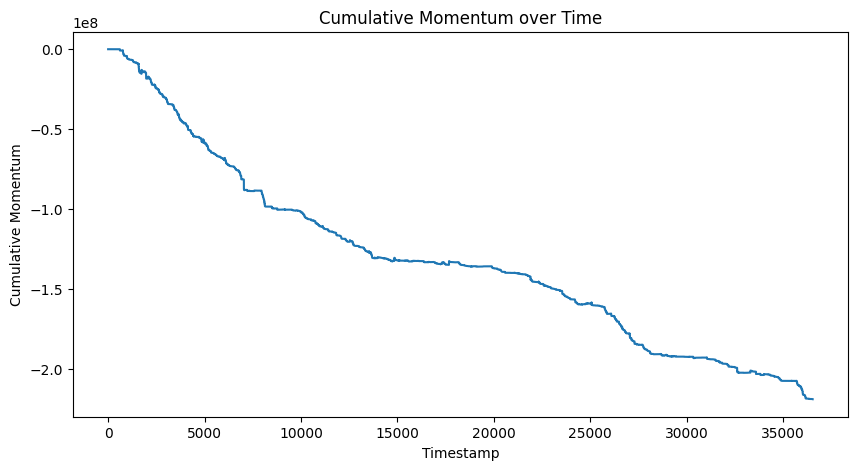

In [278]:
plot_cumulative_momentum(cumulative_momentum)

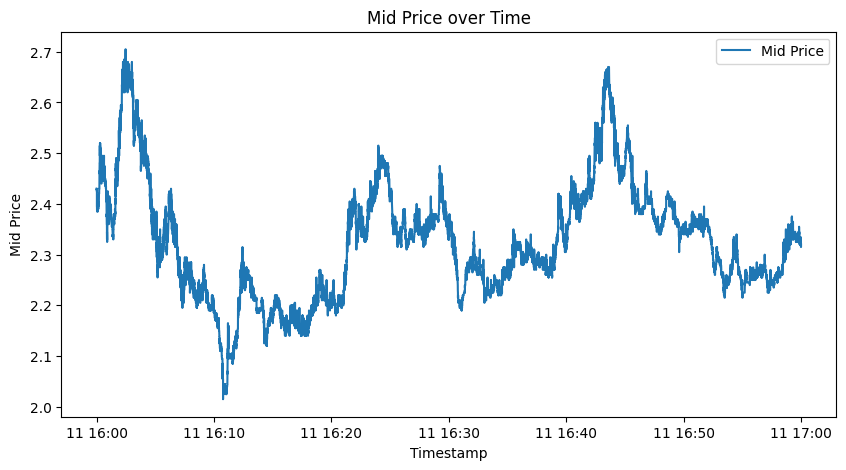

In [275]:
plot_mid_price(price_df, limit=100000)

In [240]:
orders_df.columns

Index(['timestamp', 'price', 'best_bid', 'best_ask', 'mid_price', 'side',
       'order_type', 'reason', 'size', 'time'],
      dtype='object')

In [292]:
accum_df[accum_df.momentum.isna()].reason

1         filled
2            NaN
3         filled
4            NaN
5         filled
           ...  
447289       NaN
447290       NaN
447292    filled
447293    filled
447294       NaN
Name: reason, Length: 397577, dtype: object

In [193]:
accum_df.velocity.notna().sum()

np.int64(29836)

In [28]:
full_channel_df.order_type.unique()

array(['limit', nan, 'market'], dtype=object)

In [29]:
full_channel_df.type.unique()

array(['received', 'open', 'match', 'done', 'change'], dtype=object)

In [30]:
full_channel_df.reason.unique()

array([nan, 'filled', 'canceled'], dtype=object)

In [33]:
ndf = full_channel_df.where(full_channel_df.order_type.isna())

In [46]:
full_channel_df[full_channel_df.order_type == 'market'].shape

(2360, 19)

In [256]:
full_channel_df[full_channel_df.order_type == 'market'].shape

(2360, 19)

In [258]:
full_channel_df[full_channel_df.type == 'match']

,order_id,order_type,size,price,client_oid,type,side,product_id,time,sequence,remaining_size,trade_id,maker_order_id,taker_order_id,reason,funds,old_size,new_size,timestamp
5,NaN,NaN,14.000,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598754,NaN,7884081.0,811f8a8f-53dc-4b0b-b106-9f6cba1eef4b,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,NaN,NaN,1652284740813739000
3,NaN,NaN,374.806,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598752,NaN,7884080.0,474813db-2329-4aba-a07b-b1adea78da8f,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,NaN,NaN,1652284740813739000
171,NaN,NaN,14.000,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:01.357997+00:00,1292598920,NaN,7884082.0,df4ec280-7d72-4f13-a79f-4f09bfeed96f,46fd14be-872e-4125-a5d2-b808f16e84b6,NaN,NaN,NaN,NaN,1652284741357997000
367,NaN,NaN,17.473,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:02.177983+00:00,1292599116,NaN,7884083.0,b1eb85bc-b2ef-40bf-b606-2d57c34b360b,d3126119-1c84-417e-826b-f24329f651a8,NaN,NaN,NaN,NaN,1652284742177983000
369,NaN,NaN,11.525,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:02.177983+00:00,1292599118,NaN,7884084.0,bb2fde8a-e60c-41eb-853d-65d788a2583b,d3126119-1c84-417e-826b-f24329f651a8,NaN,NaN,NaN,NaN,1652284742177983000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768261,NaN,NaN,0.428,2.33,NaN,match,sell,WLUNA-USD,2022-05-11 16:59:52.913315+00:00,1293367010,NaN,7922509.0,bd093610-4dd4-419c-9d2e-208ae2a465bf,cfbef5ba-ea97-4007-b79d-3209d85573ba,NaN,NaN,NaN,NaN,1652288392913315000
768264,NaN,NaN,13.771,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.921821+00:00,1293367013,NaN,7922510.0,76b22ba0-975e-4efa-be94-bf71ea5464ae,22d3c8a0-3942-4315-aa07-a89f2d09f15e,NaN,NaN,NaN,NaN,1652288392921821000
768266,NaN,NaN,6.229,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.921821+00:00,1293367015,NaN,7922511.0,17bd2f80-a385-4ad4-b904-94537b6cb3c2,22d3c8a0-3942-4315-aa07-a89f2d09f15e,NaN,NaN,NaN,NaN,1652288392921821000
768271,NaN,NaN,15.732,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.935290+00:00,1293367020,NaN,7922513.0,6025f56a-f1a6-49a6-9dba-3c4c62af7272,16efdc4e-f04e-43df-baf4-5ebb76c21285,NaN,NaN,NaN,NaN,1652288392935290000


In [262]:
#maker_order_id
#811f8a8f-53dc-4b0b-b106-9f6cba1eef4b
#474813db-2329-4aba-a07b-b1adea78da8f

#taker_order_id
#0299ed2d-d33d-4313-a1d4-b74ce9cc9f26

In [273]:
full_channel_df[(full_channel_df.order_id == '0299ed2d-d33d-4313-a1d4-b74ce9cc9f26') | (full_channel_df.order_id == '811f8a8f-53dc-4b0b-b106-9f6cba1eef4b') | (full_channel_df.order_id == '474813db-2329-4aba-a07b-b1adea78da8f')]

,order_id,order_type,size,price,client_oid,type,side,product_id,time,sequence,remaining_size,trade_id,maker_order_id,taker_order_id,reason,funds,old_size,new_size,timestamp
6,811f8a8f-53dc-4b0b-b106-9f6cba1eef4b,NaN,NaN,2.33,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598755,0.000,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284740813739000
2,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,limit,2324.238,2.33,b1f276a7-e271-4c82-9fa7-a55451507f82,received,sell,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1652284740813739000
7,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,2.33,NaN,done,sell,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598756,1935.432,NaN,NaN,NaN,canceled,NaN,NaN,NaN,1652284740813739000
4,474813db-2329-4aba-a07b-b1adea78da8f,NaN,NaN,2.33,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598753,0.000,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284740813739000


When order_type is **NaN**, type can be **open**, **match**, **done**, **change** (order change/trade)  
When order_type is **limit** or **market**, type is **received** (order creation)  

When order_type is **NaN**, reason can be **NaN**, **filled**, **canceled** ()  
When order_type is **limit** or **market**, reason can be **NaN**  

